<a href="https://colab.research.google.com/github/srikanthreddyn111/Chest-X-ray-pulmonary-tuberculosis-using-deep-learning/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy matplotlib opencv-python scikit-learn pillow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
✅ Loading existing trained model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step


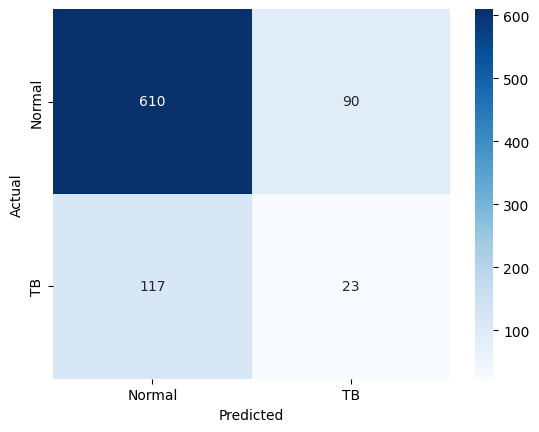

              precision    recall  f1-score   support

      Normal       0.84      0.87      0.85       700
          TB       0.20      0.16      0.18       140

    accuracy                           0.75       840
   macro avg       0.52      0.52      0.52       840
weighted avg       0.73      0.75      0.74       840



In [ ]:
# Import Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define Paths
data_dir = '/content/drive/MyDrive/Datasets/TB_Chest_Radiography_Database/'
model_path = '/content/drive/MyDrive/Datasets/tb_cxr_model.h5'  # save model in Drive
img_size = (224, 224)

# Data Preprocessing and Augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_gen.flow_from_directory(
    data_dir,
    classes=['Normal', 'Tuberculosis'],  # restrict classes explicitly
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    data_dir,
    classes=['Normal', 'Tuberculosis'],
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# ✅ Check if saved model already exists
if os.path.exists(model_path):
    print("✅ Loading existing trained model...")
    model = load_model(model_path)
else:
    print("🚀 Training new model (first time)...")
    # Build CNN Model
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Train model once
    history = model.fit(train_data, validation_data=val_data, epochs=20)

    # Plot Accuracy and Loss
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend(), plt.title('Accuracy'), plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(), plt.title('Loss'), plt.grid()
    plt.show()

    # Save trained model
    model.save(model_path)
    print("💾 Model trained and saved successfully!")

# Evaluate the loaded or newly trained model
val_preds = (model.predict(val_data) > 0.5).astype(int)
cm = confusion_matrix(val_data.classes, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','TB'], yticklabels=['Normal','TB'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(val_data.classes, val_preds, target_names=['Normal', 'TB'], labels=[0,1]))


✅ Model loaded successfully!


Saving patient6.png to patient6 (1).png
Saving patient7.png to patient7 (1).png

📸 User uploaded file: patient6 (1).png


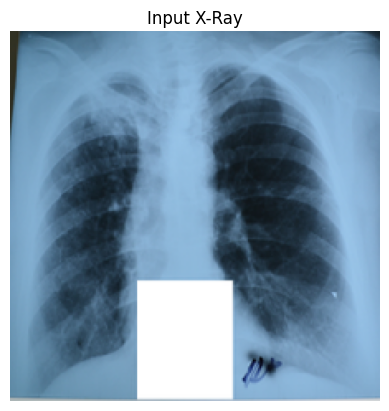

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
🧠 Prediction: Tuberculosis Positive ✅

📸 User uploaded file: patient7 (1).png


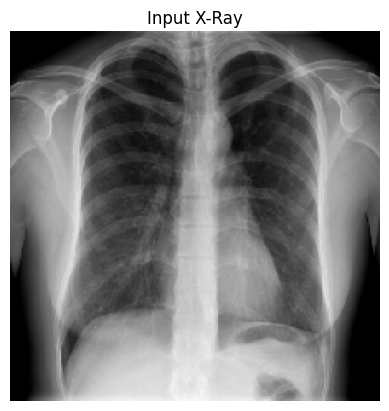

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
🫁 Prediction: Normal Chest X-Ray


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# Load trained model (make sure tb_cxr_model.h5 is in your working directory or Drive path)
model_path = "/content/drive/MyDrive/Datasets/tb_cxr_model.h5"
model = load_model(model_path)
print("✅ Model loaded successfully!")

# Prediction function — handles one or more uploaded files
def predict_tb_uploaded():
    # Upload file dialog
    uploaded = files.upload()

    # Iterate through uploaded files
    for filename in uploaded.keys():
        if not os.path.exists(filename):
            print(f"⚠️ Error: File {filename} not found.")
            continue

        print(f"\n📸 User uploaded file: {filename}")

        # Load and preprocess image
        img = load_img(filename, target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Input X-Ray")
        plt.show()

        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)[0][0]

        # Display results
        if prediction > 0.5:
            print("🧠 Prediction: Tuberculosis Positive ✅")
        else:
            print("🫁 Prediction: Normal Chest X-Ray")

# Run the prediction interface
predict_tb_uploaded()
